In [1]:
%run IDM_helper_functions.ipynb

In [2]:
from pyddm import Model
from pyddm.models import DriftConstant, DriftLinear, NoiseConstant, BoundConstant, OverlayNonDecision, ICPointSourceCenter
from pyddm.functions import fit_adjust_model, display_model

from pyddm import Fittable, Fitted, Sample
from pyddm.models import LossRobustBIC, LossBIC, LossLikelihood, LossRobustLikelihood,LossSquaredError
from pyddm.functions import fit_adjust_model

In [3]:
import pandas as pd
import os
import scipy.io as sio
import scipy
from statsmodels.stats.anova import AnovaRM


In [6]:
directory = "/Users/wangjiashun/Desktop/SAT-Rafiei"
sub = 1
session = 1
file = directory+"/Subject "+str(sub)+"/Session"+str(session)
file

'/Users/wangjiashun/Desktop/SAT-Rafiei/Subject 1/Session1'

In [95]:
data_session_sub = sio.loadmat(file)["p"]

In [101]:
import seaborn as sns


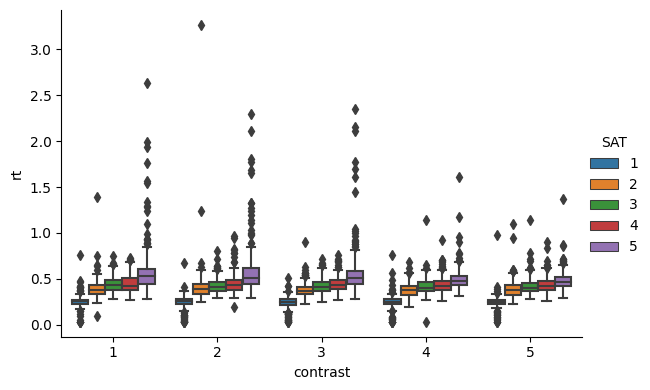

In [113]:
#df_check = df_sub[df_sub.SAT == ]
#df_check = df_sub[df_sub.contrast == 5]

sns.catplot(data=df_sub, x="contrast", y="rt", hue="SAT", kind="box",
            height=4, aspect=6/4)

In [35]:
rt.shape

(1, 50)

# Data preprocessing


In [38]:
for sub in range(30): # over participants

    df_sub = pd.DataFrame(columns = ['contrast', 'SAT', 'rt', 'correct'],)
    for session in range(5): # over session
        file = directory+"/Subject "+str(sub+1)+"/Session"+str(session+1)+'.mat'
        #print(os.path.exists(file))
        if not os.path.exists(file):
            break
        
        data_session_sub = sio.loadmat(file)["p"]

        for i in range(4): # over runs
            for j in range(5): # over blocks
                
                contrast = data_session_sub["data"][0,0][i,j]["contrast"][0,0][0,:]
                rt = data_session_sub["data"][0,0][i,j]["rt"][0,0][0,:]
                correct = data_session_sub["data"][0,0][i,j]["correct"][0,0][0,:]
                
                
                # only keep rt < 3s
                
                contrast = contrast[rt<3]
                correct = correct[rt<3]
                
                rt = rt[rt<3]
                
                SAT = [data_session_sub["condition"][0,0][i,j]]*rt.shape[0]
                ##

                df_block = pd.DataFrame({'contrast':contrast, 
                                         'SAT':np.array(SAT), 
                                         'rt':rt, 
                                         'correct':correct})
                df_sub = df_sub.append(df_block)

    #print(max(df_sub["rt"]))
    df_sub.to_csv('data_sub'+str(sub+1)+'.csv')


In [135]:
i = 0
path = os.path.join(data_dir+str(i+1)+".csv")
df = pd.read_csv(path)
df

,Unnamed: 0,contrast,SAT,rt,correct
0,0,1,2,0.333174,0
1,1,1,2,0.254905,1
2,2,3,2,0.229423,0
3,3,2,2,0.243612,0
4,4,5,2,0.226315,1
...,...,...,...,...,...
4995,45,1,3,0.279900,0
4996,46,5,3,0.325039,0
4997,47,2,3,0.408336,0
4998,48,4,3,0.438938,1


In [41]:
data_dir = "/Users/wangjiashun/Desktop/SAT-Rafiei/data/data_sub"
df_all = pd.DataFrame(columns = ['contrast', 'SAT', 'participant', 'v','a','ter','k'],)


i=1
for sub in range(10):
    for contrast in range(5):
        for SAT in range(5):
            print(i)
            i+=1
    
            path = os.path.join(data_dir+str(sub+1)+".csv")
            df = pd.read_csv(path)
            df = df[df["contrast"]==contrast+1] # one contrast condition
            df = df[df["SAT"]==SAT+1] # # one SAT condition

            data_sub = np.stack((np.array((df["rt"])), np.array((df["correct"]))), axis = 1)
            samp = Sample.from_numpy_array(data_sub, column_names = [])

            model_fit = Model(name='Simple model (fitted)',
                          drift=DriftLinear(drift=Fittable(minval=0, maxval=6),
                                            t = 0,
                                            x=Fittable(minval=-30, maxval=30)),
                          noise=NoiseConstant(noise=1),
                          bound=BoundConstant(B=Fittable(minval=0.5, maxval=10)),
                          overlay=OverlayNonDecision(nondectime=Fittable(minval=0.1, maxval=1)),
                          dx=.001, dt=.001, T_dur=3)

            fit_adjust_model(samp, model_fit,
                             fitting_method="differential_evolution",
                             lossfunction=LossRobustBIC, verbose=False)
            
            df_sub = pd.DataFrame(columns = ['contrast', 'SAT', 'participant', 'v','a','ter','k'],)

            df_sub = pd.DataFrame({'contrast':contrast+1, 
                                   'SAT':SAT+1, 
                                   'participant': sub + 1,
                                   'v': np.array(model_fit.parameters()['drift']['drift']), 
                                   'a': np.array(model_fit.parameters()['bound']['B']),
                                   'ter': np.array(model_fit.parameters()['overlay']['nondectime']),
                                   'k': np.array(model_fit.parameters()['drift']['x'])
                                  }, index=[i])
            
            df_all = df_all.append(df_sub)

            print(df_sub)


1


Info: Params [ 0.         17.04404669  1.56888819  0.10030937] gave 356.93476392480017


   contrast  SAT  participant    v         a       ter          k
2         1    1            1  0.0  1.568888  0.100309  17.044047
2


Info: Params [0.57989579 8.47304194 0.95446641 0.18538511] gave -37.07874708323662


   contrast  SAT  participant         v         a       ter         k
3         1    2            1  0.579896  0.954466  0.185385  8.473042
3


Info: Params [ 0.28888993 11.15486296  3.31899484  0.13966468] gave -135.65831073861253


   contrast  SAT  participant        v         a       ter          k
4         1    3            1  0.28889  3.318995  0.139665  11.154863
4


Info: Params [ 0.07169834 10.61380593  4.56865352  0.10335488] gave -96.66191132177791


   contrast  SAT  participant         v         a       ter          k
5         1    4            1  0.071698  4.568654  0.103355  10.613806
5


Info: Params [0.51066951 3.78733511 0.94448513 0.22598933] gave 154.35739526142845


   contrast  SAT  participant        v         a       ter         k
6         1    5            1  0.51067  0.944485  0.225989  3.787335
6


Info: Params [ 0.30507798 11.72801749  0.78213039  0.10054443] gave 1148.4643451318557


   contrast  SAT  participant         v        a       ter          k
7         2    1            1  0.305078  0.78213  0.100544  11.728017
7


Info: Params [ 0.43123518 10.03390905  1.34708259  0.17007835] gave -146.57518621152957


   contrast  SAT  participant         v         a       ter          k
8         2    2            1  0.431235  1.347083  0.170078  10.033909
8


Info: Params [ 0.35111193 12.9742943   7.09129256  0.10171125] gave -183.75256272825447


   contrast  SAT  participant         v         a       ter          k
9         2    3            1  0.351112  7.091293  0.101711  12.974294
9


Info: Params [0.45212908 9.68580957 4.06720354 0.10080618] gave -90.19761026215117


    contrast  SAT  participant         v         a       ter        k
10         2    4            1  0.452129  4.067204  0.100806  9.68581
10


Info: Params [0.77248125 4.33315228 0.92077517 0.25384074] gave 125.84989152120563


    contrast  SAT  participant         v         a       ter         k
11         2    5            1  0.772481  0.920775  0.253841  4.333152
11


Info: Params [ 0.33492807 11.47546502  0.7081537   0.10077391] gave 1158.4310587399493


    contrast  SAT  participant         v         a       ter          k
12         3    1            1  0.334928  0.708154  0.100774  11.475465
12


Info: Params [ 0.91406561 12.75651393  4.03722522  0.10816581] gave -214.36249520603474


    contrast  SAT  participant         v         a       ter          k
13         3    2            1  0.914066  4.037225  0.108166  12.756514
13


Info: Params [ 0.6752468  10.45325933  2.48918255  0.14003736] gave -134.79225912038055


    contrast  SAT  participant         v         a       ter          k
14         3    3            1  0.675247  2.489183  0.140037  10.453259
14


Info: Params [1.03395759 9.70690653 2.4868069  0.15128563] gave -151.76006472935524


    contrast  SAT  participant         v         a       ter         k
15         3    4            1  1.033958  2.486807  0.151286  9.706907
15


Info: Params [0.98539449 4.50781553 1.04952306 0.23177703] gave 78.48516373831917


    contrast  SAT  participant         v         a       ter         k
16         3    5            1  0.985394  1.049523  0.231777  4.507816
16


Info: Params [3.59727758e-03 1.70999302e+01 1.61107082e+00 1.00678429e-01] gave 897.008056056933


    contrast  SAT  participant         v         a       ter         k
17         4    1            1  0.003597  1.611071  0.100678  17.09993
17


Info: Params [ 0.4994433  10.47927779  2.36202631  0.10259573] gave -139.7941881819511


    contrast  SAT  participant         v         a       ter          k
18         4    2            1  0.499443  2.362026  0.102596  10.479278
18


Info: Params [1.29925445 9.38604418 0.86675482 0.23654957] gave -102.73105466607007


    contrast  SAT  participant         v         a      ter         k
19         4    3            1  1.299254  0.866755  0.23655  9.386044
19


Info: Params [2.01762586 8.02666129 1.039154   0.23118746] gave -240.32637711947842


    contrast  SAT  participant         v         a       ter         k
20         4    4            1  2.017626  1.039154  0.231187  8.026661
20


Info: Params [2.33608503 6.62415271 1.10366085 0.27289079] gave -233.1063870377966


    contrast  SAT  participant         v         a       ter         k
21         4    5            1  2.336085  1.103661  0.272891  6.624153
21


Info: Params [3.64268338e-03 1.16148500e+01 7.82212756e-01 1.00955258e-01] gave 568.4304556543336


    contrast  SAT  participant         v         a       ter         k
22         5    1            1  0.003643  0.782213  0.100955  11.61485
22


Info: Params [1.45547843 8.71525958 1.03479919 0.18422884] gave -180.2763805583627


    contrast  SAT  participant         v         a       ter        k
23         5    2            1  1.455478  1.034799  0.184229  8.71526
23


Info: Params [2.47253672 4.35183823 0.5997178  0.25811415] gave -285.5027563400626


    contrast  SAT  participant         v         a       ter         k
24         5    3            1  2.472537  0.599718  0.258114  4.351838
24


Info: Params [1.97079518 8.67852311 1.1135744  0.23200276] gave -251.6018274358167


    contrast  SAT  participant         v         a       ter         k
25         5    4            1  1.970795  1.113574  0.232003  8.678523
25


Info: Params [2.61115637 5.32764444 1.17060511 0.24396381] gave -254.16844627781182


    contrast  SAT  participant         v         a       ter         k
26         5    5            1  2.611156  1.170605  0.243964  5.327644
26


Info: Params [ 0.        30.         1.6598685  0.1503848] gave 460.45109170667433


    contrast  SAT  participant    v         a       ter     k
27         1    1            2  0.0  1.659868  0.150385  30.0
27


Info: Params [ 0.         20.55709129  1.83068916  0.1005786 ] gave 33.39501467262767


    contrast  SAT  participant    v         a       ter          k
28         1    2            2  0.0  1.830689  0.100579  20.557091
28


Info: Params [0.         2.0961145  0.92638937 0.10345793] gave 82.36823624375097


    contrast  SAT  participant    v         a       ter         k
29         1    3            2  0.0  0.926389  0.103458  2.096114
29


Info: Params [0.         2.04659991 0.82418882 0.31295383] gave 72.31082338105685


    contrast  SAT  participant    v         a       ter       k
30         1    4            2  0.0  0.824189  0.312954  2.0466
30


Info: Params [0.         4.49251933 2.39660647 0.20742499] gave 63.01315865233732


    contrast  SAT  participant    v         a       ter         k
31         1    5            2  0.0  2.396606  0.207425  4.492519
31


Info: Params [ 0.22673166 30.          3.52934557  0.12035156] gave 177.30098725476913


    contrast  SAT  participant         v         a       ter     k
32         2    1            2  0.226732  3.529346  0.120352  30.0
32


Info: Params [ 0.         30.          2.39233598  0.13700541] gave -1.0039343382099855


    contrast  SAT  participant    v         a       ter     k
33         2    2            2  0.0  2.392336  0.137005  30.0
33


Info: Params [ 0.0058778  -5.12105073  0.5015286   0.20188513] gave 74.0051088213781


    contrast  SAT  participant         v         a       ter         k
34         2    3            2  0.005878  0.501529  0.201885 -5.121051
34


Info: Params [0.28897891 4.04184644 1.98764786 0.13271857] gave 62.31947690828982


    contrast  SAT  participant         v         a       ter         k
35         2    4            2  0.288979  1.987648  0.132719  4.041846
35


Info: Params [0.         2.03822228 1.27720507 0.10088412] gave 104.58735353778899


    contrast  SAT  participant    v         a       ter         k
36         2    5            2  0.0  1.277205  0.100884  2.038222
36


Info: Params [ 0.         10.08591821  0.55528391  0.10063992] gave 92.17756929217607


    contrast  SAT  participant    v         a      ter          k
37         3    1            2  0.0  0.555284  0.10064  10.085918
37


Info: Params [0.08964249 8.78759676 0.60631287 0.10094862] gave 88.59289040984049


    contrast  SAT  participant         v         a       ter         k
38         3    2            2  0.089642  0.606313  0.100949  8.787597
38


Info: Params [0.         0.26048024 0.76704121 0.10601737] gave 94.79112213048998


    contrast  SAT  participant    v         a       ter        k
39         3    3            2  0.0  0.767041  0.106017  0.26048
39


Info: Params [ 0.         -2.50688361  0.5648483   0.30283888] gave 75.88180906708683


    contrast  SAT  participant    v         a       ter         k
40         3    4            2  0.0  0.564848  0.302839 -2.506884
40


Info: Params [0.65283504 2.21169032 1.67652221 0.11253647] gave 87.93069304859692


    contrast  SAT  participant         v         a       ter        k
41         3    5            2  0.652835  1.676522  0.112536  2.21169
41


Info: Params [ 0.         17.92278133  1.5160157   0.10037525] gave 132.75078727295187


    contrast  SAT  participant    v         a       ter          k
42         4    1            2  0.0  1.516016  0.100375  17.922781
42


Info: Params [ 0.         12.16557914  0.94468046  0.10093628] gave 71.92369996375788


    contrast  SAT  participant    v        a       ter          k
43         4    2            2  0.0  0.94468  0.100936  12.165579
43


Info: Params [0.         3.13357406 1.20409877 0.1119016 ] gave 75.91065464258662


    contrast  SAT  participant    v         a       ter         k
44         4    3            2  0.0  1.204099  0.111902  3.133574
44


Info: Params [0.06356895 3.38893406 1.65367598 0.18135278] gave 76.19447371591481


    contrast  SAT  participant         v         a       ter         k
45         4    4            2  0.063569  1.653676  0.181353  3.388934
45


Info: Params [0.08625955 3.4762854  1.31561359 0.31407777] gave 71.01767790668515


    contrast  SAT  participant        v         a       ter         k
46         4    5            2  0.08626  1.315614  0.314078  3.476285
46


Info: Params [ 0.         17.1906133   1.32040325  0.10242857] gave 137.65108339804345


    contrast  SAT  participant    v         a       ter          k
47         5    1            2  0.0  1.320403  0.102429  17.190613
47


Info: Params [ 0.14001509 22.42455328  0.62365817  0.1776218 ] gave 210.85894384874788


    contrast  SAT  participant         v         a       ter          k
48         5    2            2  0.140015  0.623658  0.177622  22.424553
48


Info: Params [ 6.15604608e-03 -7.47195655e+00  5.00137658e-01  1.00084246e-01] gave 126.19531793625572


    contrast  SAT  participant         v         a       ter         k
49         5    3            2  0.006156  0.500138  0.100084 -7.471957
49


Info: Params [0.33867905 3.68776153 1.01638182 0.40120068] gave 58.80323478668824


    contrast  SAT  participant         v         a       ter         k
50         5    4            2  0.338679  1.016382  0.401201  3.687762
50


Info: Params [0.26196629 2.87124363 2.26246037 0.10886313] gave 89.95370309201975


    contrast  SAT  participant         v        a       ter         k
51         5    5            2  0.261966  2.26246  0.108863  2.871244
51


Info: Params [0.08173647 6.35090369 1.24832516 0.10041469] gave 344.88704465989787


    contrast  SAT  participant         v         a       ter         k
52         1    1            3  0.081736  1.248325  0.100415  6.350904
52


Info: Params [ 0.68889273 10.07460915  7.27710809  0.10006143] gave -113.7961589729605


    contrast  SAT  participant         v         a       ter          k
53         1    2            3  0.688893  7.277108  0.100061  10.074609
53


Info: Params [ 0.57830771 10.66326147  4.94646721  0.18158106] gave -111.84403045504784


    contrast  SAT  participant         v         a       ter          k
54         1    3            3  0.578308  4.946467  0.181581  10.663261
54


Info: Params [1.33015903 7.56100977 1.01573868 0.32437476] gave -74.56387157581823


    contrast  SAT  participant         v         a       ter        k
55         1    4            3  1.330159  1.015739  0.324375  7.56101
55


Info: Params [0.53071502 3.96802755 0.79599385 0.34656119] gave 114.43261610151033


    contrast  SAT  participant         v         a       ter         k
56         1    5            3  0.530715  0.795994  0.346561  3.968028
56


Info: Params [0.31404532 6.68586954 1.34131274 0.10008583] gave 129.48444257469424


    contrast  SAT  participant         v         a       ter        k
57         2    1            3  0.314045  1.341313  0.100086  6.68587
57


Info: Params [ 1.31490314 11.28335273  8.41620472  0.12601097] gave -101.50709888101993


    contrast  SAT  participant         v         a       ter          k
58         2    2            3  1.314903  8.416205  0.126011  11.283353
58


Info: Params [1.26475894 9.62033446 0.79942889 0.33869759] gave -171.78992782018727


    contrast  SAT  participant         v         a       ter         k
59         2    3            3  1.264759  0.799429  0.338698  9.620334
59


Info: Params [1.32469959 6.95125275 0.89315922 0.31969781] gave -78.60377006968251


    contrast  SAT  participant       v         a       ter         k
60         2    4            3  1.3247  0.893159  0.319698  6.951253
60


Info: Params [1.13706883 4.86572244 1.31511234 0.27459201] gave 76.42082407100217


    contrast  SAT  participant         v         a       ter         k
61         2    5            3  1.137069  1.315112  0.274592  4.865722
61


Info: Params [0.56127431 6.40664735 1.25444027 0.10081227] gave 26.3855538847961


    contrast  SAT  participant         v        a       ter         k
62         3    1            3  0.561274  1.25444  0.100812  6.406647
62


Info: Params [ 2.21339627 11.86575845  8.02173648  0.15190934] gave -303.8090974549309


    contrast  SAT  participant         v         a       ter          k
63         3    2            3  2.213396  8.021736  0.151909  11.865758
63


Info: Params [2.05533668 8.05687202 0.82012308 0.33343598] gave -211.5437139529198


    contrast  SAT  participant         v         a       ter         k
64         3    3            3  2.055337  0.820123  0.333436  8.056872
64


Info: Params [2.51999231 7.47320238 0.85220622 0.34285039] gave -279.063206820224


    contrast  SAT  participant         v         a      ter         k
65         3    4            3  2.519992  0.852206  0.34285  7.473202
65


Info: Params [1.72842416 3.56793574 1.26142693 0.26895101] gave -16.049842148917552


    contrast  SAT  participant         v         a       ter         k
66         3    5            3  1.728424  1.261427  0.268951  3.567936
66


Info: Params [1.16061534 4.65049035 0.97804529 0.11165342] gave 361.32468657263865


    contrast  SAT  participant         v         a       ter        k
67         4    1            3  1.160615  0.978045  0.111653  4.65049
67


Info: Params [2.44554551 8.56853672 1.39851492 0.25966334] gave -228.49399262182106


    contrast  SAT  participant         v         a       ter         k
68         4    2            3  2.445546  1.398515  0.259663  8.568537
68


Info: Params [2.98174768 9.98235483 8.75426197 0.12620263] gave -362.20181113060846


    contrast  SAT  participant         v         a       ter         k
69         4    3            3  2.981748  8.754262  0.126203  9.982355
69


Info: Params [3.51512353 6.79598388 1.01288535 0.32480969] gave -391.276047612351


    contrast  SAT  participant         v         a      ter         k
70         4    4            3  3.515124  1.012885  0.32481  6.795984
70


Info: Params [2.53919444 3.22029556 1.79022237 0.21100438] gave -188.8304209142114


    contrast  SAT  participant         v         a       ter         k
71         4    5            3  2.539194  1.790222  0.211004  3.220296
71


Info: Params [1.50417365 4.05555618 0.89522835 0.12007773] gave -52.696017288755314


    contrast  SAT  participant         v         a       ter         k
72         5    1            3  1.504174  0.895228  0.120078  4.055556
72


Info: Params [ 3.9932314  11.387522    9.7472218   0.14628244] gave -510.58200436953433


    contrast  SAT  participant         v         a       ter          k
73         5    2            3  3.993231  9.747222  0.146282  11.387522
73


Info: Params [3.51501129 8.70666402 2.60187621 0.22381721] gave -433.45707258640454


    contrast  SAT  participant         v         a       ter         k
74         5    3            3  3.515011  2.601876  0.223817  8.706664
74


Info: Params [4.11988253 5.00659128 0.8215924  0.33020421] gave -492.31383385378825


    contrast  SAT  participant         v         a       ter         k
75         5    4            3  4.119883  0.821592  0.330204  5.006591
75


Info: Params [3.07239006 5.17040453 1.18913375 0.30631409] gave -290.4026413186907


    contrast  SAT  participant        v         a       ter         k
76         5    5            3  3.07239  1.189134  0.306314  5.170405
76


Info: Params [ 0.         12.59241223  1.46054883  0.10094019] gave 21.23229526203202


    contrast  SAT  participant    v         a      ter          k
77         1    1            4  0.0  1.460549  0.10094  12.592412
77


Info: Params [ 0.02105318 13.66215578  2.14593723  0.12752569] gave -209.87783121267952


    contrast  SAT  participant         v         a       ter          k
78         1    2            4  0.021053  2.145937  0.127526  13.662156
78


Info: Params [ 0.01787836 11.67941249  3.95097594  0.10379794] gave -137.33799899457784


    contrast  SAT  participant         v         a       ter          k
79         1    3            4  0.017878  3.950976  0.103798  11.679412
79


Info: Params [ 0.61581395 11.38433022  7.07554923  0.10053506] gave -146.18485663580017


    contrast  SAT  participant         v         a       ter         k
80         1    4            4  0.615814  7.075549  0.100535  11.38433
80


Info: Params [0.39213751 9.46176285 6.32826967 0.10684866] gave -56.223179008301884


    contrast  SAT  participant         v        a       ter         k
81         1    5            4  0.392138  6.32827  0.106849  9.461763
81


Info: Params [ 0.33910499 14.31147654  0.50753196  0.19398183] gave -202.0917192301159


    contrast  SAT  participant         v         a       ter          k
82         2    1            4  0.339105  0.507532  0.193982  14.311477
82


Info: Params [ 0.20723264 13.61180487  2.26847237  0.11877495] gave -207.50973626730564


    contrast  SAT  participant         v         a       ter          k
83         2    2            4  0.207233  2.268472  0.118775  13.611805
83


Info: Params [ 0.32124491 11.21100681  3.07820328  0.11178257] gave -133.8342345786944


    contrast  SAT  participant         v         a       ter          k
84         2    3            4  0.321245  3.078203  0.111783  11.211007
84


Info: Params [ 0.44736684 10.68782589  5.33988913  0.1017448 ] gave -116.61214245861954


    contrast  SAT  participant         v         a       ter          k
85         2    4            4  0.447367  5.339889  0.101745  10.687826
85


Info: Params [0.88607408 5.04188807 0.76320025 0.28916401] gave -59.37840502405051


    contrast  SAT  participant         v       a       ter         k
86         2    5            4  0.886074  0.7632  0.289164  5.041888
86


Info: Params [ 0.23426914 16.54038458  2.52493464  0.10035987] gave -87.79213655408712


    contrast  SAT  participant         v         a      ter          k
87         3    1            4  0.234269  2.524935  0.10036  16.540385
87


Info: Params [ 0.19314344 13.99941088  3.22969992  0.10001146] gave -226.1763564700873


    contrast  SAT  participant         v       a       ter          k
88         3    2            4  0.193143  3.2297  0.100011  13.999411
88


Info: Params [0.85283924 9.18222002 2.3729399  0.10009586] gave -115.82198863097797


    contrast  SAT  participant         v        a       ter        k
89         3    3            4  0.852839  2.37294  0.100096  9.18222
89


Info: Params [ 1.24151617 11.03299463  3.68317633  0.15126482] gave -201.10025427738435


    contrast  SAT  participant         v         a       ter          k
90         3    4            4  1.241516  3.683176  0.151265  11.032995
90


Info: Params [1.58154001 8.04658651 0.96305915 0.28862602] gave -153.5946116927082


    contrast  SAT  participant        v         a       ter         k
91         3    5            4  1.58154  0.963059  0.288626  8.046587
91


Info: Params [ 0.42192472 15.42554383  0.73442079  0.16962925] gave -187.66745633033938


    contrast  SAT  participant         v         a       ter          k
92         4    1            4  0.421925  0.734421  0.169629  15.425544
92


Info: Params [ 0.61824574 13.03688424  2.62608705  0.1008656 ] gave -210.18455857851083


    contrast  SAT  participant         v         a       ter          k
93         4    2            4  0.618246  2.626087  0.100866  13.036884
93


Info: Params [ 0.79263632 11.0225231   1.78718614  0.15750775] gave -184.590968422317


    contrast  SAT  participant         v         a       ter          k
94         4    3            4  0.792636  1.787186  0.157508  11.022523
94


Info: Params [2.03184798 8.34632533 1.27466865 0.22699667] gave -245.5927670840137


    contrast  SAT  participant         v         a       ter         k
95         4    4            4  2.031848  1.274669  0.226997  8.346325
95


Info: Params [2.53092498 6.1527477  0.95284433 0.29031143] gave -257.15104457221275


    contrast  SAT  participant         v         a       ter         k
96         4    5            4  2.530925  0.952844  0.290311  6.152748
96


Info: Params [ 0.13094399 13.04689435  1.6503124   0.10073688] gave 115.63506119917866


    contrast  SAT  participant         v         a       ter          k
97         5    1            4  0.130944  1.650312  0.100737  13.046894
97


Info: Params [ 0.9632976  11.5046954   0.66420775  0.20507358] gave -237.91086291189862


    contrast  SAT  participant         v         a       ter          k
98         5    2            4  0.963298  0.664208  0.205074  11.504695
98


Info: Params [1.52417829 9.94822482 1.15828659 0.19513844] gave -236.62233141974627


    contrast  SAT  participant         v         a       ter         k
99         5    3            4  1.524178  1.158287  0.195138  9.948225
99


Info: Params [2.73910643 6.75676567 1.29261816 0.22053854] gave -317.827528052663


     contrast  SAT  participant         v         a       ter         k
100         5    4            4  2.739106  1.292618  0.220539  6.756766
100


Info: Params [3.73825667 5.51803678 1.11757611 0.28779282] gave -415.71195943177116


     contrast  SAT  participant         v         a       ter         k
101         5    5            4  3.738257  1.117576  0.287793  5.518037
101


Info: Params [ 0.16547902 10.42955813  0.72185791  0.1007666 ] gave 1143.7869673571288


     contrast  SAT  participant         v         a       ter          k
102         1    1            5  0.165479  0.721858  0.100767  10.429558
102


Info: Params [0.         9.87494591 1.25744422 0.10074087] gave 295.319794719363


     contrast  SAT  participant    v         a       ter         k
103         1    2            5  0.0  1.257444  0.100741  9.874946
103


Info: Params [0.41956949 9.13521375 2.57248647 0.1004661 ] gave -75.90142823882167


     contrast  SAT  participant         v         a       ter         k
104         1    3            5  0.419569  2.572486  0.100466  9.135214
104


Info: Params [0.56136477 5.75067348 2.25889869 0.1004653 ] gave 95.33633922847125


     contrast  SAT  participant         v         a       ter         k
105         1    4            5  0.561365  2.258899  0.100465  5.750673
105


Info: Params [0.61065416 5.18129231 1.5968076  0.20904745] gave 136.37551944981107


     contrast  SAT  participant         v         a       ter         k
106         1    5            5  0.610654  1.596808  0.209047  5.181292
106


Info: Params [4.03255139e-03 1.04808957e+01 7.24195263e-01 1.00916032e-01] gave 597.4108627538077


     contrast  SAT  participant         v         a       ter          k
107         2    1            5  0.004033  0.724195  0.100916  10.480896
107


Info: Params [ 0.07566101 13.27537708  2.15246271  0.10318665] gave 272.67752719831236


     contrast  SAT  participant         v         a       ter          k
108         2    2            5  0.075661  2.152463  0.103187  13.275377
108


Info: Params [0.39957372 8.05280499 2.16628024 0.10090828] gave -23.439376848483295


     contrast  SAT  participant         v        a       ter         k
109         2    3            5  0.399574  2.16628  0.100908  8.052805
109


Info: Params [0.71146389 6.61439539 3.09534487 0.10002887] gave 42.80738527293664


     contrast  SAT  participant         v         a       ter         k
110         2    4            5  0.711464  3.095345  0.100029  6.614395
110


Info: Params [0.77251346 4.79937277 1.67232591 0.17802367] gave 132.77785290301182


     contrast  SAT  participant         v         a       ter         k
111         2    5            5  0.772513  1.672326  0.178024  4.799373
111


Info: Params [7.04262573e-03 1.03936986e+01 7.11180418e-01 1.00543208e-01] gave 2044.6923498584251


     contrast  SAT  participant         v        a       ter          k
112         3    1            5  0.007043  0.71118  0.100543  10.393699
112


Info: Params [ 0.32673708 11.5620978   1.75300648  0.1007254 ] gave 315.9047502815036


     contrast  SAT  participant         v         a       ter          k
113         3    2            5  0.326737  1.753006  0.100725  11.562098
113


Info: Params [0.54540473 9.14526168 1.95408043 0.14392687] gave -81.8723420961452


     contrast  SAT  participant         v        a       ter         k
114         3    3            5  0.545405  1.95408  0.143927  9.145262
114


Info: Params [1.18435706 7.34979245 1.78146258 0.19838957] gave -65.5089762174829


     contrast  SAT  participant         v         a      ter         k
115         3    4            5  1.184357  1.781463  0.19839  7.349792
115


Info: Params [1.22971476 4.54673948 1.00226531 0.25449263] gave 48.297204149545266


     contrast  SAT  participant         v         a       ter         k
116         3    5            5  1.229715  1.002265  0.254493  4.546739
116


Info: Params [ 0.0276871  13.92290884  1.07522242  0.10025772] gave 789.452335967139


     contrast  SAT  participant         v         a       ter          k
117         4    1            5  0.027687  1.075222  0.100258  13.922909
117


Info: Params [0.25907369 7.081537   0.77594513 0.10031728] gave 787.2016939579808


     contrast  SAT  participant         v         a       ter         k
118         4    2            5  0.259074  0.775945  0.100317  7.081537
118


Info: Params [1.16863429 9.25208789 0.98666112 0.20531271] gave -161.69714483024427


     contrast  SAT  participant         v         a       ter         k
119         4    3            5  1.168634  0.986661  0.205313  9.252088
119


Info: Params [1.89272868 7.16742262 1.74619574 0.19417367] gave -169.884669715394


     contrast  SAT  participant         v         a       ter         k
120         4    4            5  1.892729  1.746196  0.194174  7.167423
120


Info: Params [2.38782301 4.51963426 1.36271068 0.24484041] gave -146.91670993121141


     contrast  SAT  participant         v         a      ter         k
121         4    5            5  2.387823  1.362711  0.24484  4.519634
121


Info: Params [ 0.24675648 12.6166726   0.81228989  0.10082913] gave 1425.5054972166681


     contrast  SAT  participant         v        a       ter          k
122         5    1            5  0.246756  0.81229  0.100829  12.616673
122


Info: Params [ 0.56575311 11.23957877  1.76148536  0.10059882] gave 123.05628740434959


     contrast  SAT  participant         v         a       ter          k
123         5    2            5  0.565753  1.761485  0.100599  11.239579
123


Info: Params [1.36840469 8.99334575 0.81735533 0.2194002 ] gave -22.209774501643256


     contrast  SAT  participant         v         a     ter         k
124         5    3            5  1.368405  0.817355  0.2194  8.993346
124


Info: Params [2.24672649 5.66371711 1.17830782 0.22287336] gave -200.03347404780774


     contrast  SAT  participant         v         a       ter         k
125         5    4            5  2.246726  1.178308  0.222873  5.663717
125


Info: Params [2.67956332 4.50383037 1.04716733 0.27237647] gave -242.94232523378554


     contrast  SAT  participant         v         a       ter        k
126         5    5            5  2.679563  1.047167  0.272376  4.50383
126


Info: Params [ 0.         10.19043464  0.91814615  0.1002061 ] gave 462.73613139633295


     contrast  SAT  participant    v         a       ter          k
127         1    1            6  0.0  0.918146  0.100206  10.190435
127


Info: Params [0.42949086 7.4880683  1.66871321 0.100693  ] gave -1.1923771230021458


     contrast  SAT  participant         v         a       ter         k
128         1    2            6  0.429491  1.668713  0.100693  7.488068
128


Info: Params [0.60237369 8.01687334 3.71297501 0.10039053] gave -54.16945278299677


     contrast  SAT  participant         v         a       ter         k
129         1    3            6  0.602374  3.712975  0.100391  8.016873
129


Info: Params [0.74097753 8.04817757 2.92142861 0.18205574] gave -29.420757693734767


     contrast  SAT  participant         v         a       ter         k
130         1    4            6  0.740978  2.921429  0.182056  8.048178
130


Info: Params [0.42480104 3.78456096 0.99277853 0.26514638] gave 133.58390099862217


     contrast  SAT  participant         v         a       ter         k
131         1    5            6  0.424801  0.992779  0.265146  3.784561
131


Info: Params [0.14523141 8.04846639 0.81155339 0.10000865] gave 562.0839234228025


     contrast  SAT  participant         v         a       ter         k
132         2    1            6  0.145231  0.811553  0.100009  8.048466
132


Info: Params [0.2903242  8.20720062 1.93953368 0.10093864] gave 144.15778268579106


     contrast  SAT  participant         v         a       ter         k
133         2    2            6  0.290324  1.939534  0.100939  8.207201
133


Info: Params [0.91148033 9.80542916 4.5215007  0.13674602] gave -138.68335595976882


     contrast  SAT  participant        v         a       ter         k
134         2    3            6  0.91148  4.521501  0.136746  9.805429
134


Info: Params [1.42909784 7.02837173 1.31863583 0.25460757] gave -98.65523475146642


     contrast  SAT  participant         v         a       ter         k
135         2    4            6  1.429098  1.318636  0.254608  7.028372
135


Info: Params [0.87633266 6.6790174  3.87501397 0.10071217] gave 9.499405300855425


     contrast  SAT  participant         v         a       ter         k
136         2    5            6  0.876333  3.875014  0.100712  6.679017
136


Info: Params [ 0.3810265  12.62674157  1.16069164  0.10084152] gave 467.03721718612013


     contrast  SAT  participant         v         a       ter          k
137         3    1            6  0.381026  1.160692  0.100842  12.626742
137


Info: Params [0.63594759 7.72369687 1.85666361 0.1001259 ] gave 45.279629957759155


     contrast  SAT  participant         v         a       ter         k
138         3    2            6  0.635948  1.856664  0.100126  7.723697
138


Info: Params [1.68775649 7.09665488 1.27373399 0.23136424] gave -160.21320248464906


     contrast  SAT  participant         v         a       ter         k
139         3    3            6  1.687756  1.273734  0.231364  7.096655
139


Info: Params [2.0014191  3.99831343 1.2375963  0.24122484] gave -135.40138781230684


     contrast  SAT  participant         v         a       ter         k
140         3    4            6  2.001419  1.237596  0.241225  3.998313
140


Info: Params [2.47110063 5.58292854 1.14227106 0.30034225] gave -212.95900735374303


     contrast  SAT  participant         v         a       ter         k
141         3    5            6  2.471101  1.142271  0.300342  5.582929
141


Info: Params [ 0.26986452 14.56159197  1.53931222  0.10030394] gave -25.97190080915134


     contrast  SAT  participant         v         a       ter          k
142         4    1            6  0.269865  1.539312  0.100304  14.561592
142


Info: Params [0.97160772 5.94985062 1.28908991 0.10022603] gave -7.033454359381402


     contrast  SAT  participant         v        a       ter         k
143         4    2            6  0.971608  1.28909  0.100226  5.949851
143


Info: Params [2.75395258 5.76340661 1.46425765 0.22026867] gave -285.2471614642017


     contrast  SAT  participant         v         a       ter         k
144         4    3            6  2.753953  1.464258  0.220269  5.763407
144


Info: Params [2.8879301  3.01431354 0.67103306 0.33180045] gave -305.62085705467655


     contrast  SAT  participant        v         a     ter         k
145         4    4            6  2.88793  0.671033  0.3318  3.014314
145


Info: Params [3.01452066 5.56122877 1.45716503 0.27211448] gave -290.17190404238494


     contrast  SAT  participant         v         a       ter         k
146         4    5            6  3.014521  1.457165  0.272114  5.561229
146


Info: Params [ 0.17985819 15.79134419  1.82170414  0.10032371] gave 318.7930798450671


     contrast  SAT  participant         v         a       ter          k
147         5    1            6  0.179858  1.821704  0.100324  15.791344
147


Info: Params [1.27713532 5.70568503 0.94302519 0.15048553] gave -74.14950919096664


     contrast  SAT  participant         v         a       ter         k
148         5    2            6  1.277135  0.943025  0.150486  5.705685
148


Info: Params [2.64951983 6.11990419 1.90422923 0.18076157] gave -280.17488821742774


     contrast  SAT  participant        v         a       ter         k
149         5    3            6  2.64952  1.904229  0.180762  6.119904
149


Info: Params [3.71177515 4.96690071 1.38470659 0.27101312] gave -383.58600271029366


     contrast  SAT  participant         v         a       ter         k
150         5    4            6  3.711775  1.384707  0.271013  4.966901
150


Info: Params [3.76380424 6.24186371 4.19417787 0.16479406] gave -386.9588126739543


     contrast  SAT  participant         v         a       ter         k
151         5    5            6  3.763804  4.194178  0.164794  6.241864
151


Info: Params [ 0.16988541 15.7888905   0.81952723  0.10094752] gave 1414.673502671484


     contrast  SAT  participant         v         a       ter          k
152         1    1            7  0.169885  0.819527  0.100948  15.788891
152


Info: Params [ 0.         11.20069425  3.56150286  0.10065258] gave -147.6814844972177


     contrast  SAT  participant    v         a       ter          k
153         1    2            7  0.0  3.561503  0.100653  11.200694
153


Info: Params [ 0.44673324 18.15726984  9.16427047  0.25064456] gave -323.79945709648376


     contrast  SAT  participant         v        a       ter         k
154         1    3            7  0.446733  9.16427  0.250645  18.15727
154


Info: Params [ 0.64850498 12.41425249  9.86118172  0.24972077] gave -197.8498237721509


     contrast  SAT  participant         v         a       ter          k
155         1    4            7  0.648505  9.861182  0.249721  12.414252
155


Info: Params [0.58305043 9.18913842 9.95469259 0.26201244] gave -73.35667020847684


     contrast  SAT  participant        v         a       ter         k
156         1    5            7  0.58305  9.954693  0.262012  9.189138
156


Info: Params [ 0.01647731 10.71214471  0.52098373  0.10036497] gave 1333.2423808638189


     contrast  SAT  participant         v         a       ter          k
157         2    1            7  0.016477  0.520984  0.100365  10.712145
157


Info: Params [ 0.13589263 12.16211636  4.75497332  0.10043427] gave -190.61219837687915


     contrast  SAT  participant         v         a       ter          k
158         2    2            7  0.135893  4.754973  0.100434  12.162116
158


Info: Params [ 0.66831261 15.97760145  9.99789144  0.22069723] gave -293.98444565035544


     contrast  SAT  participant         v         a       ter          k
159         2    3            7  0.668313  9.997891  0.220697  15.977601
159


Info: Params [ 0.85167443 10.9466937   9.05103435  0.22297227] gave -177.4732891341944


     contrast  SAT  participant         v         a       ter          k
160         2    4            7  0.851674  9.051034  0.222972  10.946694
160


Info: Params [1.06947441 9.70182541 6.02343283 0.33553389] gave -139.60996745645343


     contrast  SAT  participant         v         a       ter         k
161         2    5            7  1.069474  6.023433  0.335534  9.701825
161


Info: Params [ 0.         12.92493867  0.65340086  0.10017635] gave 959.8884197090111


     contrast  SAT  participant    v         a       ter          k
162         3    1            7  0.0  0.653401  0.100176  12.924939
162


Info: Params [ 0.55845346 10.77528432  3.35704938  0.10075551] gave -169.85549754655563


     contrast  SAT  participant         v         a       ter          k
163         3    2            7  0.558453  3.357049  0.100756  10.775284
163


Info: Params [ 1.84282508 15.64606067  8.9761174   0.22786695] gave -372.0302281652825


     contrast  SAT  participant         v         a       ter          k
164         3    3            7  1.842825  8.976117  0.227867  15.646061
164


Info: Params [ 1.75300234 11.2750954   1.60464143  0.38455155] gave -282.25183572362727


     contrast  SAT  participant         v         a       ter          k
165         3    4            7  1.753002  1.604641  0.384552  11.275095
165


Info: Params [1.37996801 7.67538586 3.8697924  0.32303651] gave -109.46707679355022


     contrast  SAT  participant         v         a       ter         k
166         3    5            7  1.379968  3.869792  0.323037  7.675386
166


Info: Params [ 0.16645551 11.84989161  0.5943456   0.10069664] gave 1227.315405232857


     contrast  SAT  participant         v         a       ter          k
167         4    1            7  0.166456  0.594346  0.100697  11.849892
167


Info: Params [ 1.28291226 11.17439398  3.71935909  0.10089416] gave -229.41193893545835


     contrast  SAT  participant         v         a       ter          k
168         4    2            7  1.282912  3.719359  0.100894  11.174394
168


Info: Params [ 1.79905145 13.82486093  9.90310733  0.18852562] gave -335.45713255318714


     contrast  SAT  participant         v         a       ter          k
169         4    3            7  1.799051  9.903107  0.188526  13.824861
169


Info: Params [2.93541659 8.41262284 2.42824068 0.32513441] gave -357.45663149832995


     contrast  SAT  participant         v         a       ter         k
170         4    4            7  2.935417  2.428241  0.325134  8.412623
170


Info: Params [2.06683882 7.54286675 8.24665222 0.22815693] gave -209.70374140142235


     contrast  SAT  participant         v         a       ter         k
171         4    5            7  2.066839  8.246652  0.228157  7.542867
171


Info: Params [0.         9.25578914 0.52930993 0.10059541] gave 1654.0762916219899


     contrast  SAT  participant    v        a       ter         k
172         5    1            7  0.0  0.52931  0.100595  9.255789
172


Info: Params [ 1.03374291 11.13538164  3.39060988  0.1025923 ] gave -216.87200539618647


     contrast  SAT  participant         v        a       ter          k
173         5    2            7  1.033743  3.39061  0.102592  11.135382
173


Info: Params [ 3.07457225 13.2061323   9.84791594  0.19006889] gave -364.82377130747557


     contrast  SAT  participant         v         a       ter          k
174         5    3            7  3.074572  9.847916  0.190069  13.206132
174


Info: Params [4.29031597 7.52026354 5.1134476  0.26380128] gave -488.8426986227168


     contrast  SAT  participant         v         a       ter         k
175         5    4            7  4.290316  5.113448  0.263801  7.520264
175


Info: Params [3.90710045 4.41285804 7.13056365 0.18712455] gave -350.1651804273932


     contrast  SAT  participant       v         a       ter         k
176         5    5            7  3.9071  7.130564  0.187125  4.412858
176


Info: Params [ 0.         11.82579936  2.140869    0.10951566] gave -19.261338945115945


     contrast  SAT  participant    v         a       ter          k
177         1    1            8  0.0  2.140869  0.109516  11.825799
177


Info: Params [0.2419993  8.18127986 2.36285054 0.10050063] gave 5.056019064233043


     contrast  SAT  participant         v         a       ter        k
178         1    2            8  0.241999  2.362851  0.100501  8.18128
178


Info: Params [0.31522419 8.52949263 2.94953183 0.10003769] gave 0.3464498152489224


     contrast  SAT  participant         v         a       ter         k
179         1    3            8  0.315224  2.949532  0.100038  8.529493
179


Info: Params [0.03554801 7.12928789 2.60888962 0.10057506] gave 18.042775808336273


     contrast  SAT  participant         v        a       ter         k
180         1    4            8  0.035548  2.60889  0.100575  7.129288
180


Info: Params [0.97653094 6.38225802 0.84057148 0.37428613] gave 4.578752405644588


     contrast  SAT  participant         v         a       ter         k
181         1    5            8  0.976531  0.840571  0.374286  6.382258
181


Info: Params [0.         9.06325491 1.46027758 0.12609945] gave 275.62269829020204


     contrast  SAT  participant    v         a       ter         k
182         2    1            8  0.0  1.460278  0.126099  9.063255
182


Info: Params [0.66950447 6.60414154 1.91466746 0.10048936] gave 16.202746689283135


     contrast  SAT  participant         v         a       ter         k
183         2    2            8  0.669504  1.914667  0.100489  6.604142
183


Info: Params [0.5613097  6.04586974 0.73986201 0.24112185] gave 10.18100159467988


     contrast  SAT  participant        v         a       ter        k
184         2    3            8  0.56131  0.739862  0.241122  6.04587
184


Info: Params [0.02273737 7.58267953 2.50628651 0.10065836] gave 13.412731415145611


     contrast  SAT  participant         v         a       ter        k
185         2    4            8  0.022737  2.506287  0.100658  7.58268
185


Info: Params [0.58873379 7.62586796 5.94444591 0.10172941] gave 10.09342015684351


     contrast  SAT  participant         v         a       ter         k
186         2    5            8  0.588734  5.944446  0.101729  7.625868
186


Info: Params [0.0879633  9.83421586 1.62102045 0.10051721] gave 176.8026648317991


     contrast  SAT  participant         v        a       ter         k
187         3    1            8  0.087963  1.62102  0.100517  9.834216
187


Info: Params [0.10943577 8.07089776 2.18311649 0.10053804] gave 6.972761211973608


     contrast  SAT  participant         v         a       ter         k
188         3    2            8  0.109436  2.183116  0.100538  8.070898
188


Info: Params [0.53936621 6.80401973 2.81418664 0.10047091] gave 14.645161322431628


     contrast  SAT  participant         v         a       ter        k
189         3    3            8  0.539366  2.814187  0.100471  6.80402
189


Info: Params [1.18305279 2.491591   0.70545856 0.20748524] gave 18.37432612145357


     contrast  SAT  participant         v         a       ter         k
190         3    4            8  1.183053  0.705459  0.207485  2.491591
190


Info: Params [ 0.82447025 10.24083492  7.43039626  0.18522958] gave -12.890247052768634


     contrast  SAT  participant        v         a      ter          k
191         3    5            8  0.82447  7.430396  0.18523  10.240835
191


Info: Params [ 1.3070494  10.33032428  0.78788085  0.19789403] gave 62.69209573720262


     contrast  SAT  participant         v         a       ter          k
192         4    1            8  1.307049  0.787881  0.197894  10.330324
192


Info: Params [0.76537554 6.87410102 1.81273927 0.12022413] gave 6.128049808475355


     contrast  SAT  participant         v         a       ter         k
193         4    2            8  0.765376  1.812739  0.120224  6.874101
193


Info: Params [1.78568086 5.26107309 0.55380218 0.32385397] gave -31.568256415520302


     contrast  SAT  participant         v         a       ter         k
194         4    3            8  1.785681  0.553802  0.323854  5.261073
194


Info: Params [1.62118007 4.6458508  0.62458446 0.27929926] gave -17.427782923046443


     contrast  SAT  participant        v         a       ter         k
195         4    4            8  1.62118  0.624584  0.279299  4.645851
195


Info: Params [2.63124723 1.83608685 1.47362126 0.17057241] gave -12.597983659303756


     contrast  SAT  participant         v         a       ter         k
196         4    5            8  2.631247  1.473621  0.170572  1.836087
196


Info: Params [1.73394045 0.94056629 0.51718348 0.18731679] gave 171.58796113060293


     contrast  SAT  participant        v         a       ter         k
197         5    1            8  1.73394  0.517183  0.187317  0.940566
197


Info: Params [1.54642679 5.9975805  0.82307079 0.20205728] gave -11.584163017185302


     contrast  SAT  participant         v         a       ter        k
198         5    2            8  1.546427  0.823071  0.202057  5.99758
198


Info: Params [1.76350689 6.20122385 0.76252403 0.25544507] gave -24.48832676929193


     contrast  SAT  participant         v         a       ter         k
199         5    3            8  1.763507  0.762524  0.255445  6.201224
199


Info: Params [1.38306104 9.0222557  1.68637964 0.18402487] gave -29.884381000939747


     contrast  SAT  participant         v        a       ter         k
200         5    4            8  1.383061  1.68638  0.184025  9.022256
200


Info: Params [6.         3.18190198 5.35628123 0.10988022] gave -91.32747712299044


     contrast  SAT  participant    v         a      ter         k
201         5    5            8  6.0  5.356281  0.10988  3.181902
201


Info: Params [0.30947435 6.83201401 0.62262648 0.10041522] gave 467.65727047567225


     contrast  SAT  participant         v         a       ter         k
202         1    1            9  0.309474  0.622626  0.100415  6.832014
202


Info: Params [0.         7.52564003 0.52568561 0.10061885] gave 366.851057524341


     contrast  SAT  participant    v         a       ter        k
203         1    2            9  0.0  0.525686  0.100619  7.52564
203


Info: Params [0.         8.69325261 0.76204821 0.10025136] gave 92.15808962215243


     contrast  SAT  participant    v         a       ter         k
204         1    3            9  0.0  0.762048  0.100251  8.693253
204


Info: Params [ 0.17713302 12.05769042  1.07825054  0.11359448] gave 72.09613513991971


     contrast  SAT  participant         v         a       ter         k
205         1    4            9  0.177133  1.078251  0.113594  12.05769
205


Info: Params [0.01626537 4.15436188 2.20493844 0.10076494] gave 58.506706702698914


     contrast  SAT  participant         v         a       ter         k
206         1    5            9  0.016265  2.204938  0.100765  4.154362
206


Info: Params [0.20502773 6.48187321 0.50111634 0.10053175] gave 190.4690692597629


     contrast  SAT  participant         v         a       ter         k
207         2    1            9  0.205028  0.501116  0.100532  6.481873
207


Info: Params [ 0.         13.09402276  0.9454902   0.10029698] gave 63.27643721912641


     contrast  SAT  participant    v        a       ter          k
208         2    2            9  0.0  0.94549  0.100297  13.094023
208


Info: Params [0.56268749 9.42837591 0.67701218 0.10086386] gave 80.05036815994366


     contrast  SAT  participant         v         a       ter         k
209         2    3            9  0.562687  0.677012  0.100864  9.428376
209


Info: Params [0.         9.18980411 0.81587464 0.10038804] gave 369.0562517412478


     contrast  SAT  participant    v         a       ter         k
210         2    4            9  0.0  0.815875  0.100388  9.189804
210


Info: Params [0.24558427 4.446762   2.24523628 0.10004073] gave 52.57238190949854


     contrast  SAT  participant         v         a       ter         k
211         2    5            9  0.245584  2.245236  0.100041  4.446762
211


Info: Params [ 1.0994061  15.15692165  0.76305994  0.1005914 ] gave 323.7571606788671


     contrast  SAT  participant         v        a       ter          k
212         3    1            9  1.099406  0.76306  0.100591  15.156922
212


Info: Params [ 0.1016821  11.24673047  0.76702531  0.10025798] gave 353.067225610292


     contrast  SAT  participant         v         a       ter         k
213         3    2            9  0.101682  0.767025  0.100258  11.24673
213


Info: Params [1.85203702e-03 4.86735947e+00 5.04074842e-01 1.00427987e-01] gave 197.5224573223691


     contrast  SAT  participant         v         a       ter         k
214         3    3            9  0.001852  0.504075  0.100428  4.867359
214


Info: Params [0.         8.35611772 0.79378338 0.10098706] gave 186.24081893782636


     contrast  SAT  participant    v         a       ter         k
215         3    4            9  0.0  0.793783  0.100987  8.356118
215


Info: Params [0.         4.60127109 2.90311993 0.1137782 ] gave 50.50134530590072


     contrast  SAT  participant    v        a       ter         k
216         3    5            9  0.0  2.90312  0.113778  4.601271
216


Info: Params [ 0.04531094 13.32917981  1.07001024  0.10050705] gave 533.4178514165299


     contrast  SAT  participant         v        a       ter         k
217         4    1            9  0.045311  1.07001  0.100507  13.32918
217


Info: Params [ 0.32666955 10.84577444  0.91496652  0.10001496] gave 451.22928047935477


     contrast  SAT  participant        v         a       ter          k
218         4    2            9  0.32667  0.914967  0.100015  10.845774
218


Info: Params [0.07165891 4.38762496 0.52024015 0.10003611] gave 560.6624131094619


     contrast  SAT  participant         v        a       ter         k
219         4    3            9  0.071659  0.52024  0.100036  4.387625
219


Info: Params [0.13785779 7.34207708 0.77236634 0.10096379] gave 287.55423536765375


     contrast  SAT  participant         v         a       ter         k
220         4    4            9  0.137858  0.772366  0.100964  7.342077
220


Info: Params [0.         3.27793145 1.58283717 0.10100569] gave 76.59715006573623


     contrast  SAT  participant    v         a       ter         k
221         4    5            9  0.0  1.582837  0.101006  3.277931
221


Info: Params [0.         7.07739465 0.50180688 0.10095738] gave 374.40088108896265


     contrast  SAT  participant    v         a       ter         k
222         5    1            9  0.0  0.501807  0.100957  7.077395
222


Info: Params [0.         4.49581025 0.51524601 0.10040908] gave 659.0611412705262


     contrast  SAT  participant    v         a       ter        k
223         5    2            9  0.0  0.515246  0.100409  4.49581
223


Info: Params [ 0.         14.20866146  1.04078486  0.10244868] gave 243.16806025750827


     contrast  SAT  participant    v         a       ter          k
224         5    3            9  0.0  1.040785  0.102449  14.208661
224


Info: Params [0.01977226 7.87817315 0.73113466 0.10078013] gave 101.94556961467939


     contrast  SAT  participant         v         a      ter         k
225         5    4            9  0.019772  0.731135  0.10078  7.878173
225


Info: Params [0.33980802 3.41641335 0.88599014 0.32813267] gave 52.95406951483718


     contrast  SAT  participant         v        a       ter         k
226         5    5            9  0.339808  0.88599  0.328133  3.416413
226


Info: Params [ 0.08996922 10.51750749  1.14167978  0.10021707] gave 636.54645006609


     contrast  SAT  participant         v        a       ter          k
227         1    1           10  0.089969  1.14168  0.100217  10.517507
227


Info: Params [0.18211422 7.45801452 1.88778751 0.10106739] gave 208.53076616921754


     contrast  SAT  participant         v         a       ter         k
228         1    2           10  0.182114  1.887788  0.101067  7.458015
228


Info: Params [0.53630533 7.58977609 3.53419666 0.10042321] gave 3.89131337771612


     contrast  SAT  participant         v         a       ter         k
229         1    3           10  0.536305  3.534197  0.100423  7.589776
229


Info: Params [0.38707894 8.17139114 5.41531743 0.10162751] gave -17.551626797596985


     contrast  SAT  participant         v         a       ter         k
230         1    4           10  0.387079  5.415317  0.101628  8.171391
230


Info: Params [0.64549703 4.05995564 0.93208651 0.3488466 ] gave 164.9714648944623


     contrast  SAT  participant         v         a       ter         k
231         1    5           10  0.645497  0.932087  0.348847  4.059956
231


Info: Params [0.06480021 5.25803599 0.69441668 0.10017759] gave 162.47581530699387


     contrast  SAT  participant       v         a       ter         k
232         2    1           10  0.0648  0.694417  0.100178  5.258036
232


Info: Params [0.2730394  8.04037888 1.82852138 0.10138494] gave -14.033894338485073


     contrast  SAT  participant         v         a       ter         k
233         2    2           10  0.273039  1.828521  0.101385  8.040379
233


Info: Params [0.82662669 8.31943163 4.95767102 0.10025361] gave -52.90962158336768


     contrast  SAT  participant         v         a       ter         k
234         2    3           10  0.826627  4.957671  0.100254  8.319432
234


Info: Params [1.0355532  8.73599928 3.54380422 0.17550447] gave -91.94509316126819


     contrast  SAT  participant         v         a       ter         k
235         2    4           10  1.035553  3.543804  0.175504  8.735999
235


Info: Params [1.04784022 4.60747279 1.00509877 0.34746437] gave 96.6864364332365


     contrast  SAT  participant        v         a       ter         k
236         2    5           10  1.04784  1.005099  0.347464  4.607473
236


Info: Params [ 0.         13.99620485  1.85314763  0.10058825] gave 63.88270843918808


     contrast  SAT  participant    v         a       ter          k
237         3    1           10  0.0  1.853148  0.100588  13.996205
237


Info: Params [0.59613266 7.06143291 1.61076647 0.10010997] gave 90.38066935078862


     contrast  SAT  participant         v         a      ter         k
238         3    2           10  0.596133  1.610766  0.10011  7.061433
238


Info: Params [1.43533168 6.79073585 1.83327999 0.18408689] gave -92.93883949320553


     contrast  SAT  participant         v        a       ter         k
239         3    3           10  1.435332  1.83328  0.184087  6.790736
239


Info: Params [1.5987687  7.53872869 1.28742951 0.27412329] gave -133.57465048457698


     contrast  SAT  participant         v        a       ter         k
240         3    4           10  1.598769  1.28743  0.274123  7.538729
240


Info: Params [2.05597894 4.38633092 1.4320359  0.29406549] gave -88.88240092239995


     contrast  SAT  participant         v         a       ter         k
241         3    5           10  2.055979  1.432036  0.294065  4.386331
241


Info: Params [0.2552935  7.1290615  0.83661243 0.1009427 ] gave 848.0709466908075


     contrast  SAT  participant         v         a       ter         k
242         4    1           10  0.255293  0.836612  0.100943  7.129061
242


Info: Params [1.34706567 5.2274522  0.67954771 0.20641469] gave -99.71174014734977


     contrast  SAT  participant         v         a       ter         k
243         4    2           10  1.347066  0.679548  0.206415  5.227452
243


Info: Params [2.60677411 6.5963876  1.0743866  0.27304199] gave -285.3242085739199


     contrast  SAT  participant         v         a       ter         k
244         4    3           10  2.606774  1.074387  0.273042  6.596388
244


Info: Params [2.65506967 6.24048344 0.9119188  0.30332528] gave -293.6822021562517


     contrast  SAT  participant        v         a       ter         k
245         4    4           10  2.65507  0.911919  0.303325  6.240483
245


Info: Params [2.7845211  6.28138091 6.88932076 0.10158088] gave -236.42797613687577


     contrast  SAT  participant         v         a       ter         k
246         4    5           10  2.784521  6.889321  0.101581  6.281381
246


Info: Params [0.66454475 6.59365201 0.83073707 0.10307437] gave 845.8251467353595


     contrast  SAT  participant         v         a       ter         k
247         5    1           10  0.664545  0.830737  0.103074  6.593652
247


Info: Params [1.41598007 5.23885933 0.72972807 0.18249883] gave -102.99679869951721


     contrast  SAT  participant        v         a       ter         k
248         5    2           10  1.41598  0.729728  0.182499  5.238859
248


Info: Params [1.89328175 7.69355213 3.83693598 0.10437498] gave -211.39580788993658


     contrast  SAT  participant         v         a       ter         k
249         5    3           10  1.893282  3.836936  0.104375  7.693552
249


Info: Params [3.00166198 6.21762602 1.04443362 0.28705082] gave -341.09952957611034


     contrast  SAT  participant         v         a       ter         k
250         5    4           10  3.001662  1.044434  0.287051  6.217626
250


Info: Params [3.2930075  6.76578425 3.63922554 0.21513202] gave -347.3006201310652


     contrast  SAT  participant         v         a       ter         k
251         5    5           10  3.293007  3.639226  0.215132  6.765784


In [53]:
df_all.to_csv('OUMresult1.csv')


In [54]:
df1 = pd.read_csv('OUMresult1.csv')
df2 = pd.read_csv('OUMresult2.csv')
df3 = pd.read_csv('OUMresult3.csv')


In [55]:
df_alls = df1.append(df2)
df_alls = df_alls.append(df3)

In [66]:
df_alls

,Unnamed: 0,contrast,SAT,participant,v,a,ter,k
0,2,1,1,1,0.000000,1.568888,0.100309,17.044047
1,3,1,2,1,0.579896,0.954466,0.185385,8.473042
2,4,1,3,1,0.288890,3.318995,0.139665,11.154863
3,5,1,4,1,0.071698,4.568654,0.103355,10.613806
4,6,1,5,1,0.510670,0.944485,0.225989,3.787335
...,...,...,...,...,...,...,...,...
245,247,5,1,30,0.000000,1.270804,0.100128,14.764992
246,248,5,2,30,2.168604,4.345238,0.176434,13.616276
247,249,5,3,30,3.925519,0.833694,0.303050,6.235077
248,250,5,4,30,3.494954,0.748982,0.306886,6.802331


In [80]:
df_alls = df_alls.rename({'contrast': 'Stimulus Contrast',
                'Drift rate': 'Drift Rate', 
                'a': 'Boundary Separation', 
                "ter": 'Non-decision Time', 
                "k": 'Effective Inhibition'
               }, axis=1)

In [82]:
df_alls.to_csv('OUMresult.csv')


In [81]:
df_alls

,Unnamed: 0,Stimulus Contrast,SAT,participant,Drift Rate,Boundary Separation,Non-decision Time,Effective Inhibition
0,2,1,1,1,0.000000,1.568888,0.100309,17.044047
1,3,1,2,1,0.579896,0.954466,0.185385,8.473042
2,4,1,3,1,0.288890,3.318995,0.139665,11.154863
3,5,1,4,1,0.071698,4.568654,0.103355,10.613806
4,6,1,5,1,0.510670,0.944485,0.225989,3.787335
...,...,...,...,...,...,...,...,...
245,247,5,1,30,0.000000,1.270804,0.100128,14.764992
246,248,5,2,30,2.168604,4.345238,0.176434,13.616276
247,249,5,3,30,3.925519,0.833694,0.303050,6.235077
248,250,5,4,30,3.494954,0.748982,0.306886,6.802331


In [46]:
import seaborn as sns
#df_all[df_all["contrast"]==3]

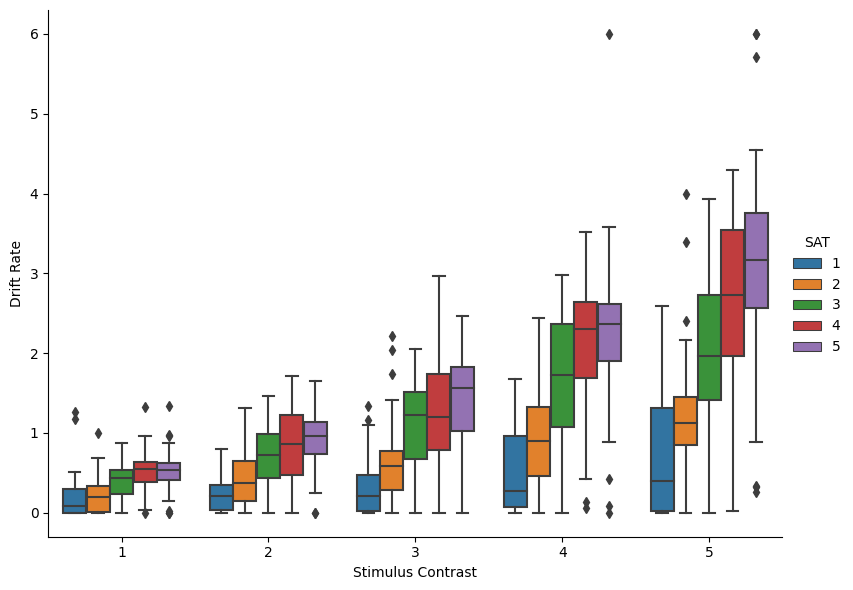

In [83]:
sns.catplot(data=df_alls, x="Stimulus Contrast", y="Drift Rate", hue="SAT", kind="box", errorbar = "ci",
            height=6, aspect=8/6)

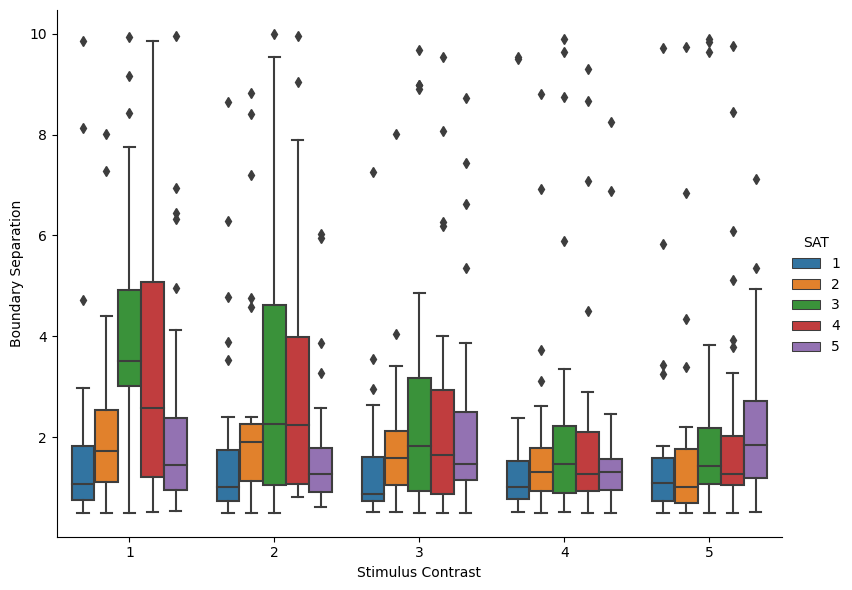

In [104]:
sns.catplot(data=df_alls, x="Stimulus Contrast", y="Boundary Separation", hue="SAT", kind="box",
            height=6, aspect=8/6)

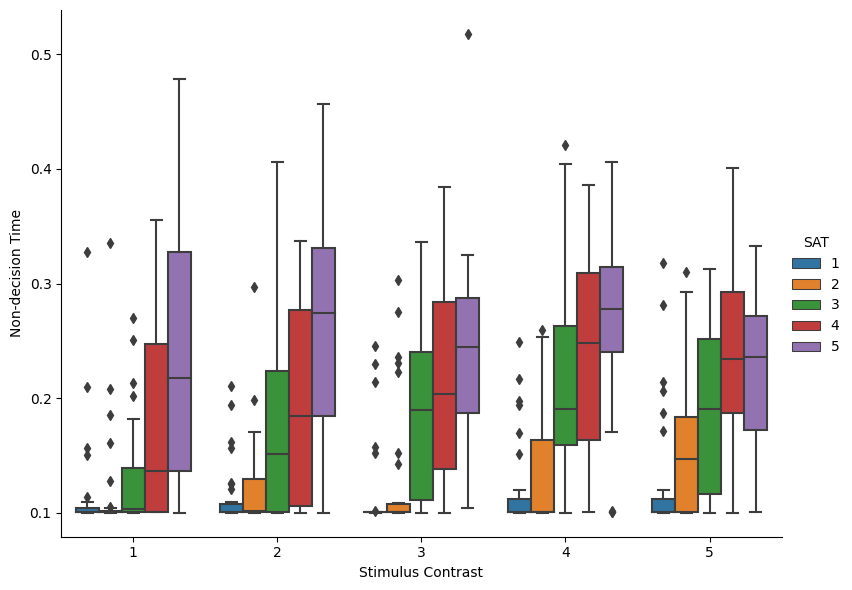

In [105]:
sns.catplot(data=df_alls, x="Stimulus Contrast", y="Non-decision Time", hue="SAT", kind="box",
            height=6, aspect=8/6)

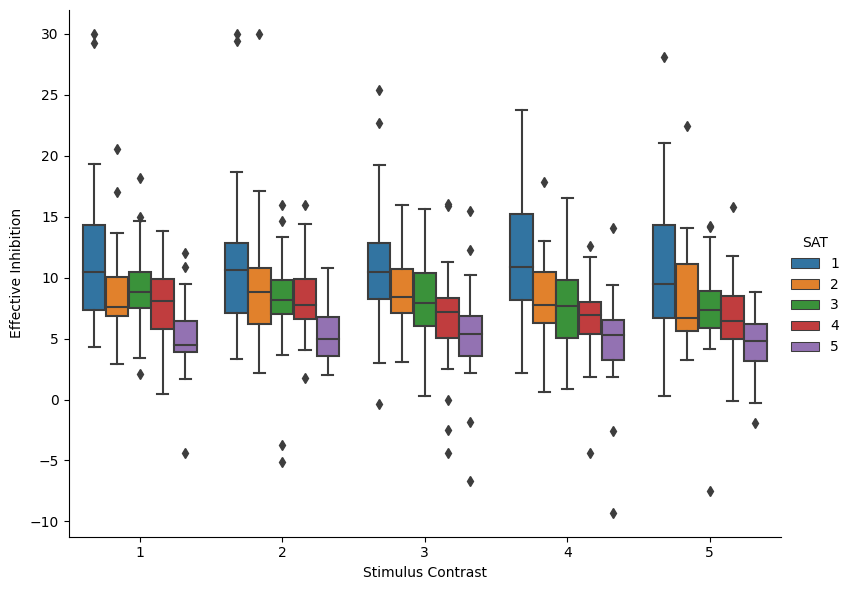

In [92]:
sns.catplot(data=df_alls, x="Stimulus Contrast", y="Effective Inhibition", hue="SAT", kind="box", errorbar = "ci",
            height=6, aspect=8/6)

In [112]:
df_example = df_alls[df_alls["Stimulus Contrast"] == 3]

In [101]:
df_example_1 = df_example[df_example["SAT"] == 1]
df_example_2 = df_example[df_example["SAT"] == 5]

In [102]:
scipy.stats.ttest_rel(df_example_1["Effective Inhibition"], df_example_2["Effective Inhibition"])

Ttest_relResult(statistic=5.695625646523247, pvalue=3.682303520044561e-06)

In [103]:
scipy.stats.ttest_rel(df_example_1["Drift Rate"], df_example_2["Drift Rate"])

Ttest_relResult(statistic=-8.498903096167965, pvalue=2.3042564318874376e-09)

In [106]:
df_example

,Unnamed: 0,Stimulus Contrast,SAT,participant,Drift Rate,Boundary Separation,Non-decision Time,Effective Inhibition
20,22,5,1,1,0.003643,0.782213,0.100955,11.614850
21,23,5,2,1,1.455478,1.034799,0.184229,8.715260
22,24,5,3,1,2.472537,0.599718,0.258114,4.351838
23,25,5,4,1,1.970795,1.113574,0.232003,8.678523
24,26,5,5,1,2.611156,1.170605,0.243964,5.327644
...,...,...,...,...,...,...,...,...
245,247,5,1,30,0.000000,1.270804,0.100128,14.764992
246,248,5,2,30,2.168604,4.345238,0.176434,13.616276
247,249,5,3,30,3.925519,0.833694,0.303050,6.235077
248,250,5,4,30,3.494954,0.748982,0.306886,6.802331


In [113]:
print(AnovaRM(data=df_example, depvar='Drift Rate',
              subject='participant', within=['SAT']).fit())

              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
SAT 31.2678 4.0000 116.0000 0.0000



In [114]:
print(AnovaRM(data=df_example, depvar='Boundary Separation',
              subject='participant', within=['SAT']).fit())


              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
SAT  2.2749 4.0000 116.0000 0.0654



In [115]:
print(AnovaRM(data=df_example, depvar='Non-decision Time',
              subject='participant', within=['SAT']).fit())


              Anova
    F Value Num DF  Den DF  Pr > F
----------------------------------
SAT 18.2300 4.0000 116.0000 0.0000

